# Convolutional Neural Network (CNN) using Keras with Tensorflow

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tqdm
import sklearn
import skimage.feature
import skimage.color
import os, sys
sys.path.append("../")
import savewally
from PIL import Image
import tensorflow as tf

# Import training patches

In [2]:
fp_pos = "../data/patches/StitchMICE_ORKlh16_3_1104_CP_FINAL.tif/positive/"
fp_neg = "../data/patches/StitchMICE_ORKlh16_3_1104_CP_FINAL.tif/negative/"

In [108]:
def read_patches(fp, luminance=True):
    patches = []
    for patch in tqdm.tqdm(os.listdir(fp)):
        patch = plt.imread(fp + patch)
        # print(patch.shape)
        if patch.shape == (50,50,3):
            if luminance:
                patch = skimage.color.rgb2gray(patch)
            patches.append(patch)
    return np.array(patches)

In [128]:
positive_patches = read_patches(fp_pos, luminance=False)

100%|█████████████████████████████████████████████████████████████████████████| 3041/3041 [00:01<00:00, 1709.04it/s]


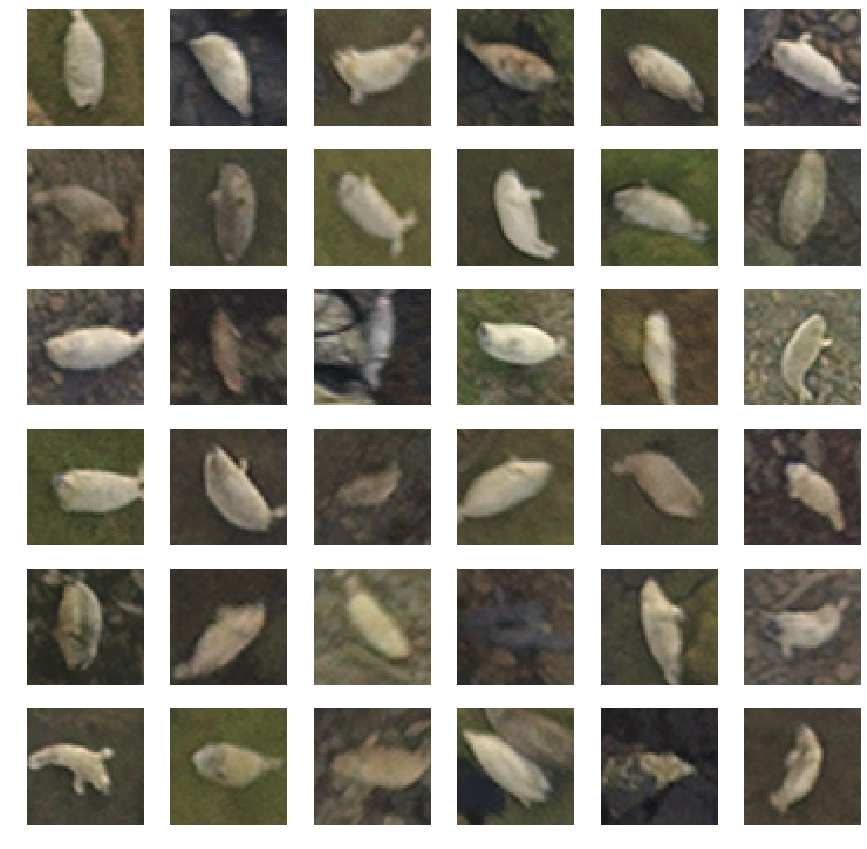

In [208]:
s = np.random.choice(positive_patches.shape[0], 36)
fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(15,15))
for im, ax in zip(positive_patches[s], axes.flat):
    ax.imshow(im)
    ax.axis('off')

In [129]:
negative_patches = read_patches(fp_neg, luminance=False)

100%|███████████████████████████████████████████████████████████████████████| 47994/47994 [00:21<00:00, 2243.27it/s]


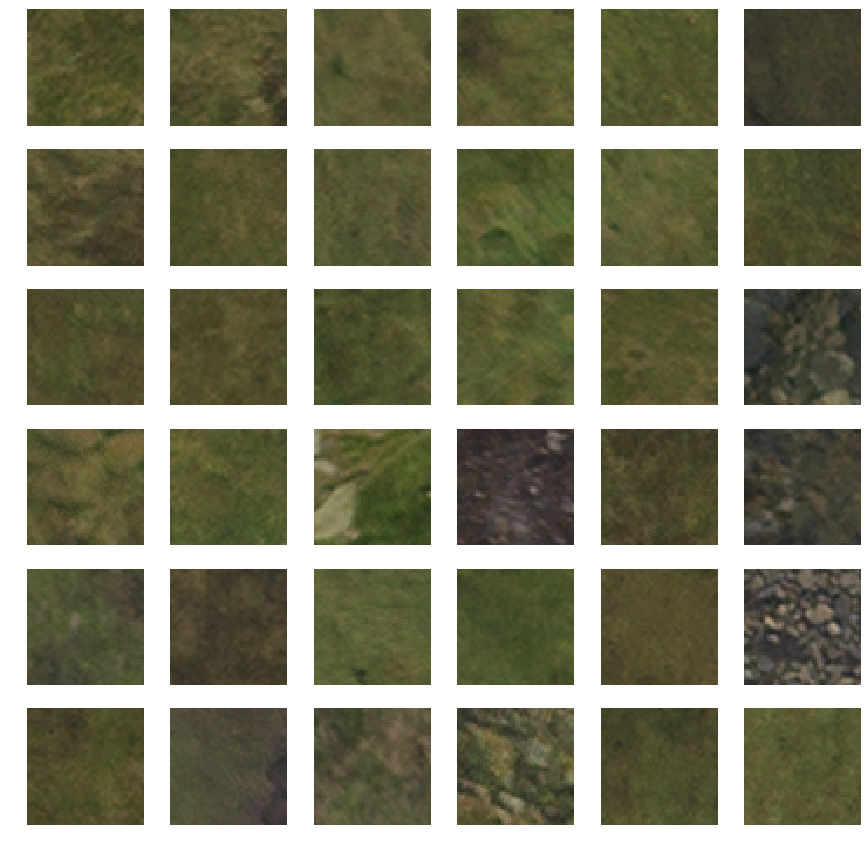

In [209]:
s = np.random.choice(negative_patches.shape[0], 36)
fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(15,15))
for im, ax in zip(negative_patches[s], axes.flat):
    ax.imshow(im)
    ax.axis('off')

In [130]:
negative_patches.shape

(47991, 50, 50, 3)

# Data pre-processing

In [155]:
patches = np.append(positive_patches, negative_patches, axis=0)
patches_bool = np.zeros((patches.shape[0]))
patches_bool[:positive_patches.shape[0]] = 1

In [156]:
patches_bool = np.stack((patches_bool, np.abs(patches_bool - 1)), axis=1)

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches,
                                                    patches_bool, 
                                                    random_state=0)

print(X_train.shape, X_test.shape)

(38274, 50, 50, 3) (12758, 50, 50, 3)


Every image has a shape of 50x50 (x3 color layers for red, blue and green)

# Building the model

In [163]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

In [164]:
# create model
model = Sequential()

In [165]:
# add model layers
model.add(Conv2D(64, kernel_size=5, activation="relu", input_shape=(50,50,3)))
model.add(Conv2D(32, kernel_size=5, activation="relu"))
model.add(Flatten())
model.add(Dense(2, activation="softmax"))

In [166]:
# compile model using acc to measure performance
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Training the model

In [ ]:
# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Save the trained model as a pickle:

# Visualize:

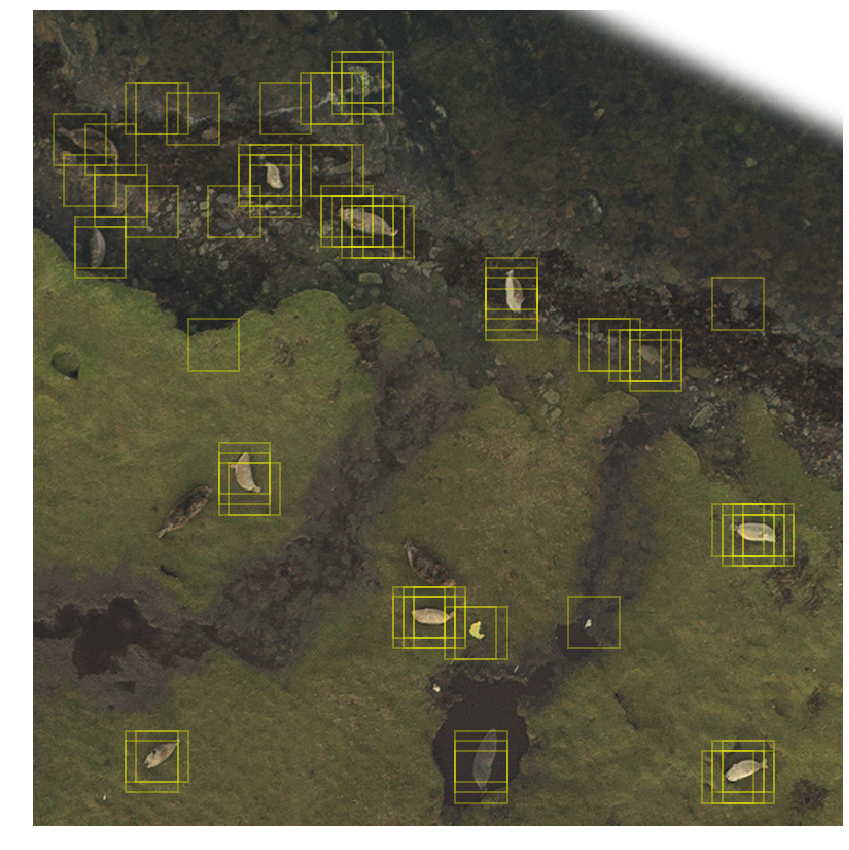

In [193]:
plot_slider_prediction_NN(Image.open("../images/test_image2.png"), model)

In [190]:
def plot_slider_prediction_NN(test_image, clf, shp=(50,50)):
    indices, patches = zip(*sliding_window(np.asarray(test_image)))
    patches = np.array(patches)
    labels = clf.predict(patches)[:,0]
    
    Ni, Nj = shp
    indices = np.array(indices)

    fig, ax = plt.subplots(figsize=(20,15))
    ax.imshow(np.asarray(test_image), cmap='gray')
    ax.axis('off')

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='yellow',
                                   alpha=0.3, lw=2, facecolor='none'))
    return ax

def sliding_window(img, istep=10, jstep=10, scale=1., patch_size=(50,50)):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

# References

* https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5